In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


# Leitura dos dados originais

In [ ]:
url_train = 'https://raw.githubusercontent.com/VitorVan/EP2-ICD/main/train.csv'
url_test = 'https://raw.githubusercontent.com/VitorVan/EP2-ICD/main/test.csv'
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

In [ ]:
print(df_train.shape)
print(df_test.shape)

(22083, 45)
(9465, 43)


In [ ]:
del df_test

# Junção de todos os dados

In [ ]:
# all_data = pd.concat([df_train, df_test])
# all_data.head(2)

In [ ]:
all_data = df_train.copy()

Existem linhas que não tem label.

In [ ]:
all_data = all_data.dropna(subset=['Disorder Subclass'])

In [ ]:
all_data.shape

(19915, 45)

In [ ]:
all_data.reset_index(drop=True, inplace=True)

# Amostragem para análise exploratória

In [ ]:
seed = 42

In [ ]:

all_data.shape

(19915, 45)

In [ ]:
# sample = all_data.sample(frac=0.1, random_state=seed)
# sample.shape

In [ ]:

# Dividir o dataset em conjunto de treino (80%) e conjunto temporário (20%)
sample, _ = train_test_split(all_data, train_size=0.8, random_state=seed, stratify = all_data["Disorder Subclass"])

In [ ]:
sample.shape

(15932, 45)

In [ ]:
sample.head(3)

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
6474,PID0x847e,6.0,No,Yes,No,No,4.845736,Teresa,Seymour,Markess,...,Singular,5.885499,abnormal,0.0,0.0,0.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
12843,PID0x7b65,3.0,No,Yes,Yes,No,4.777097,Miranda,Oles,Patron,...,Singular,8.572872,normal,1.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
18650,PID0x7ab2,9.0,Yes,Yes,Yes,Yes,4.612090,Deborah,Flowers,Jayzier,...,Singular,8.863608,abnormal,0.0,1.0,0.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes


In [ ]:
sample.to_csv('exploratory_analysis_sample.csv', index=False)

In [ ]:
#modeling_data = all_data.drop(sample.index.tolist())
modeling_data = all_data.copy()
modeling_data.head(2)

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis


In [ ]:
sample.isnull().mean().mean() * 100

9.197282896755656

In [ ]:
sample.isnull().mean() * 100

Patient Id                                           0.000000
Patient Age                                          6.239016
Genes in mother's side                               0.000000
Inherited from father                                1.324379
Maternal gene                                       12.170475
Paternal gene                                        0.000000
Blood cell count (mcL)                               0.000000
Patient First Name                                   0.000000
Family Name                                         41.652021
Father's name                                        0.000000
Mother's age                                        26.060758
Father's age                                        25.615114
Institute Name                                      21.911875
Location of Institute                                0.000000
Status                                               0.000000
Respiratory Rate (breaths/min)                       9.245544
Heart Ra

In [ ]:
sample.replace('-', np.nan, inplace=True)
sample.replace('Not available', np.nan, inplace=True)
sample.replace('No record', np.nan, inplace=True)

In [ ]:
sample.isnull().mean().mean() * 100

12.300750411470974

In [ ]:
modeling_data.shape[0] + sample.shape[0] == all_data.shape[0]

False

In [ ]:
modeling_data.to_csv('modeling_data.csv', index=False)

# Remoção de variáveis que vamos descartar

In [ ]:
rem_cols = ['Patient First Name', 'Father\'s name', 'Patient Id', 'Family Name', 'Institute Name', 'Location of Institute',
            'Parental consent', 'Genetic Disorder', 'Place of birth',
            'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5', 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']
sample = sample.drop(rem_cols, axis=1)
sample.head(2)

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Disorder Subclass
6474,6.0,No,Yes,No,No,4.845736,47.0,24.0,Deceased,Tachypnea,...,No,NaN,NaN,No,No,0.0,Singular,5.885499,abnormal,Leigh syndrome
12843,3.0,No,Yes,Yes,No,4.777097,18.0,40.0,Deceased,Normal (30-60),...,No,No,Yes,Yes,Yes,0.0,Singular,8.572872,normal,Diabetes


# Análise Exploratória

## Labels

In [ ]:
frequencia_labels = sample['Disorder Subclass'].value_counts()
print(frequencia_labels)

Disorder Subclass
Leigh syndrome                         4128
Mitochondrial myopathy                 3524
Cystic fibrosis                        2758
Tay-Sachs                              2266
Diabetes                               1454
Hemochromatosis                        1084
Leber's hereditary optic neuropathy     518
Alzheimer's                             122
Cancer                                   78
Name: count, dtype: int64


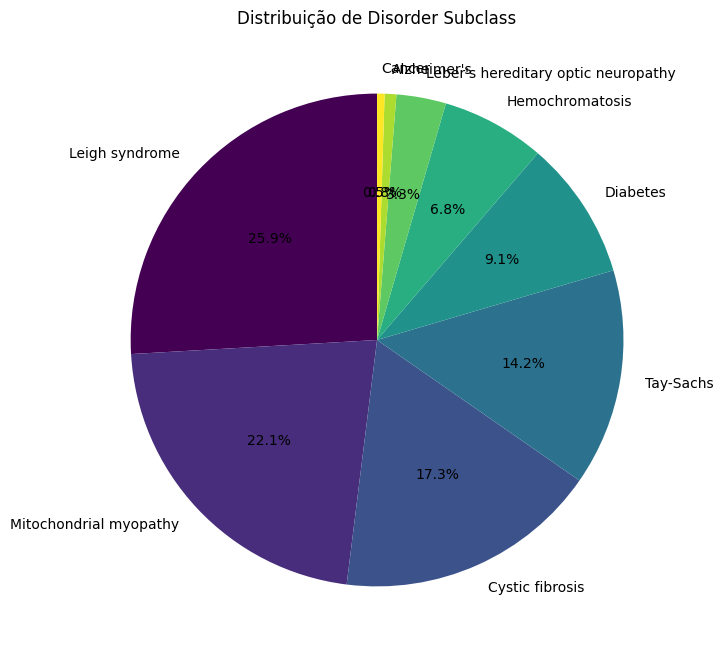

In [ ]:
labels = frequencia_labels.index
data = frequencia_labels.values

# Criar o gráfico de pizza
plt.figure(figsize=(10, 8))
frequencia_labels.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribuição de Disorder Subclass')
plt.ylabel('')  # Remover o rótulo do eixo y
plt.show()

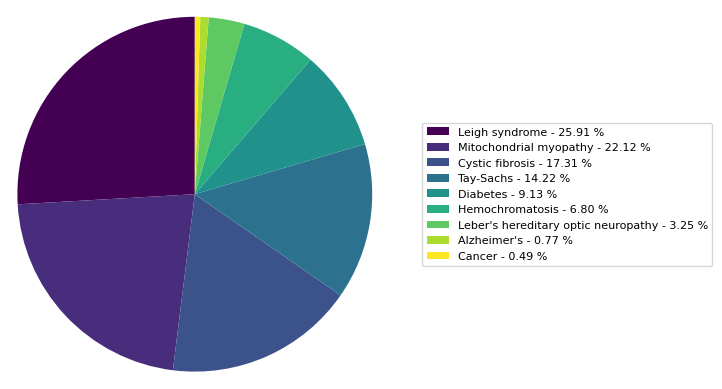

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

porcent = 100. * data / data.sum()

legend_labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(labels, porcent)]

patches, texts = plt.pie(data, colors=colors[:len(data)], startangle=90, radius=1.2)

sort_legend = True
if sort_legend:
    patches, legend_labels, dummy = zip(*sorted(zip(patches, legend_labels, data), key=lambda x: x[2], reverse=True))

plt.legend(patches, legend_labels, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=8)

# Save the pie chart
plt.savefig('piechart.png', bbox_inches='tight')

# Alternatively, display the pie chart
plt.show()

## Correlação de Pearson

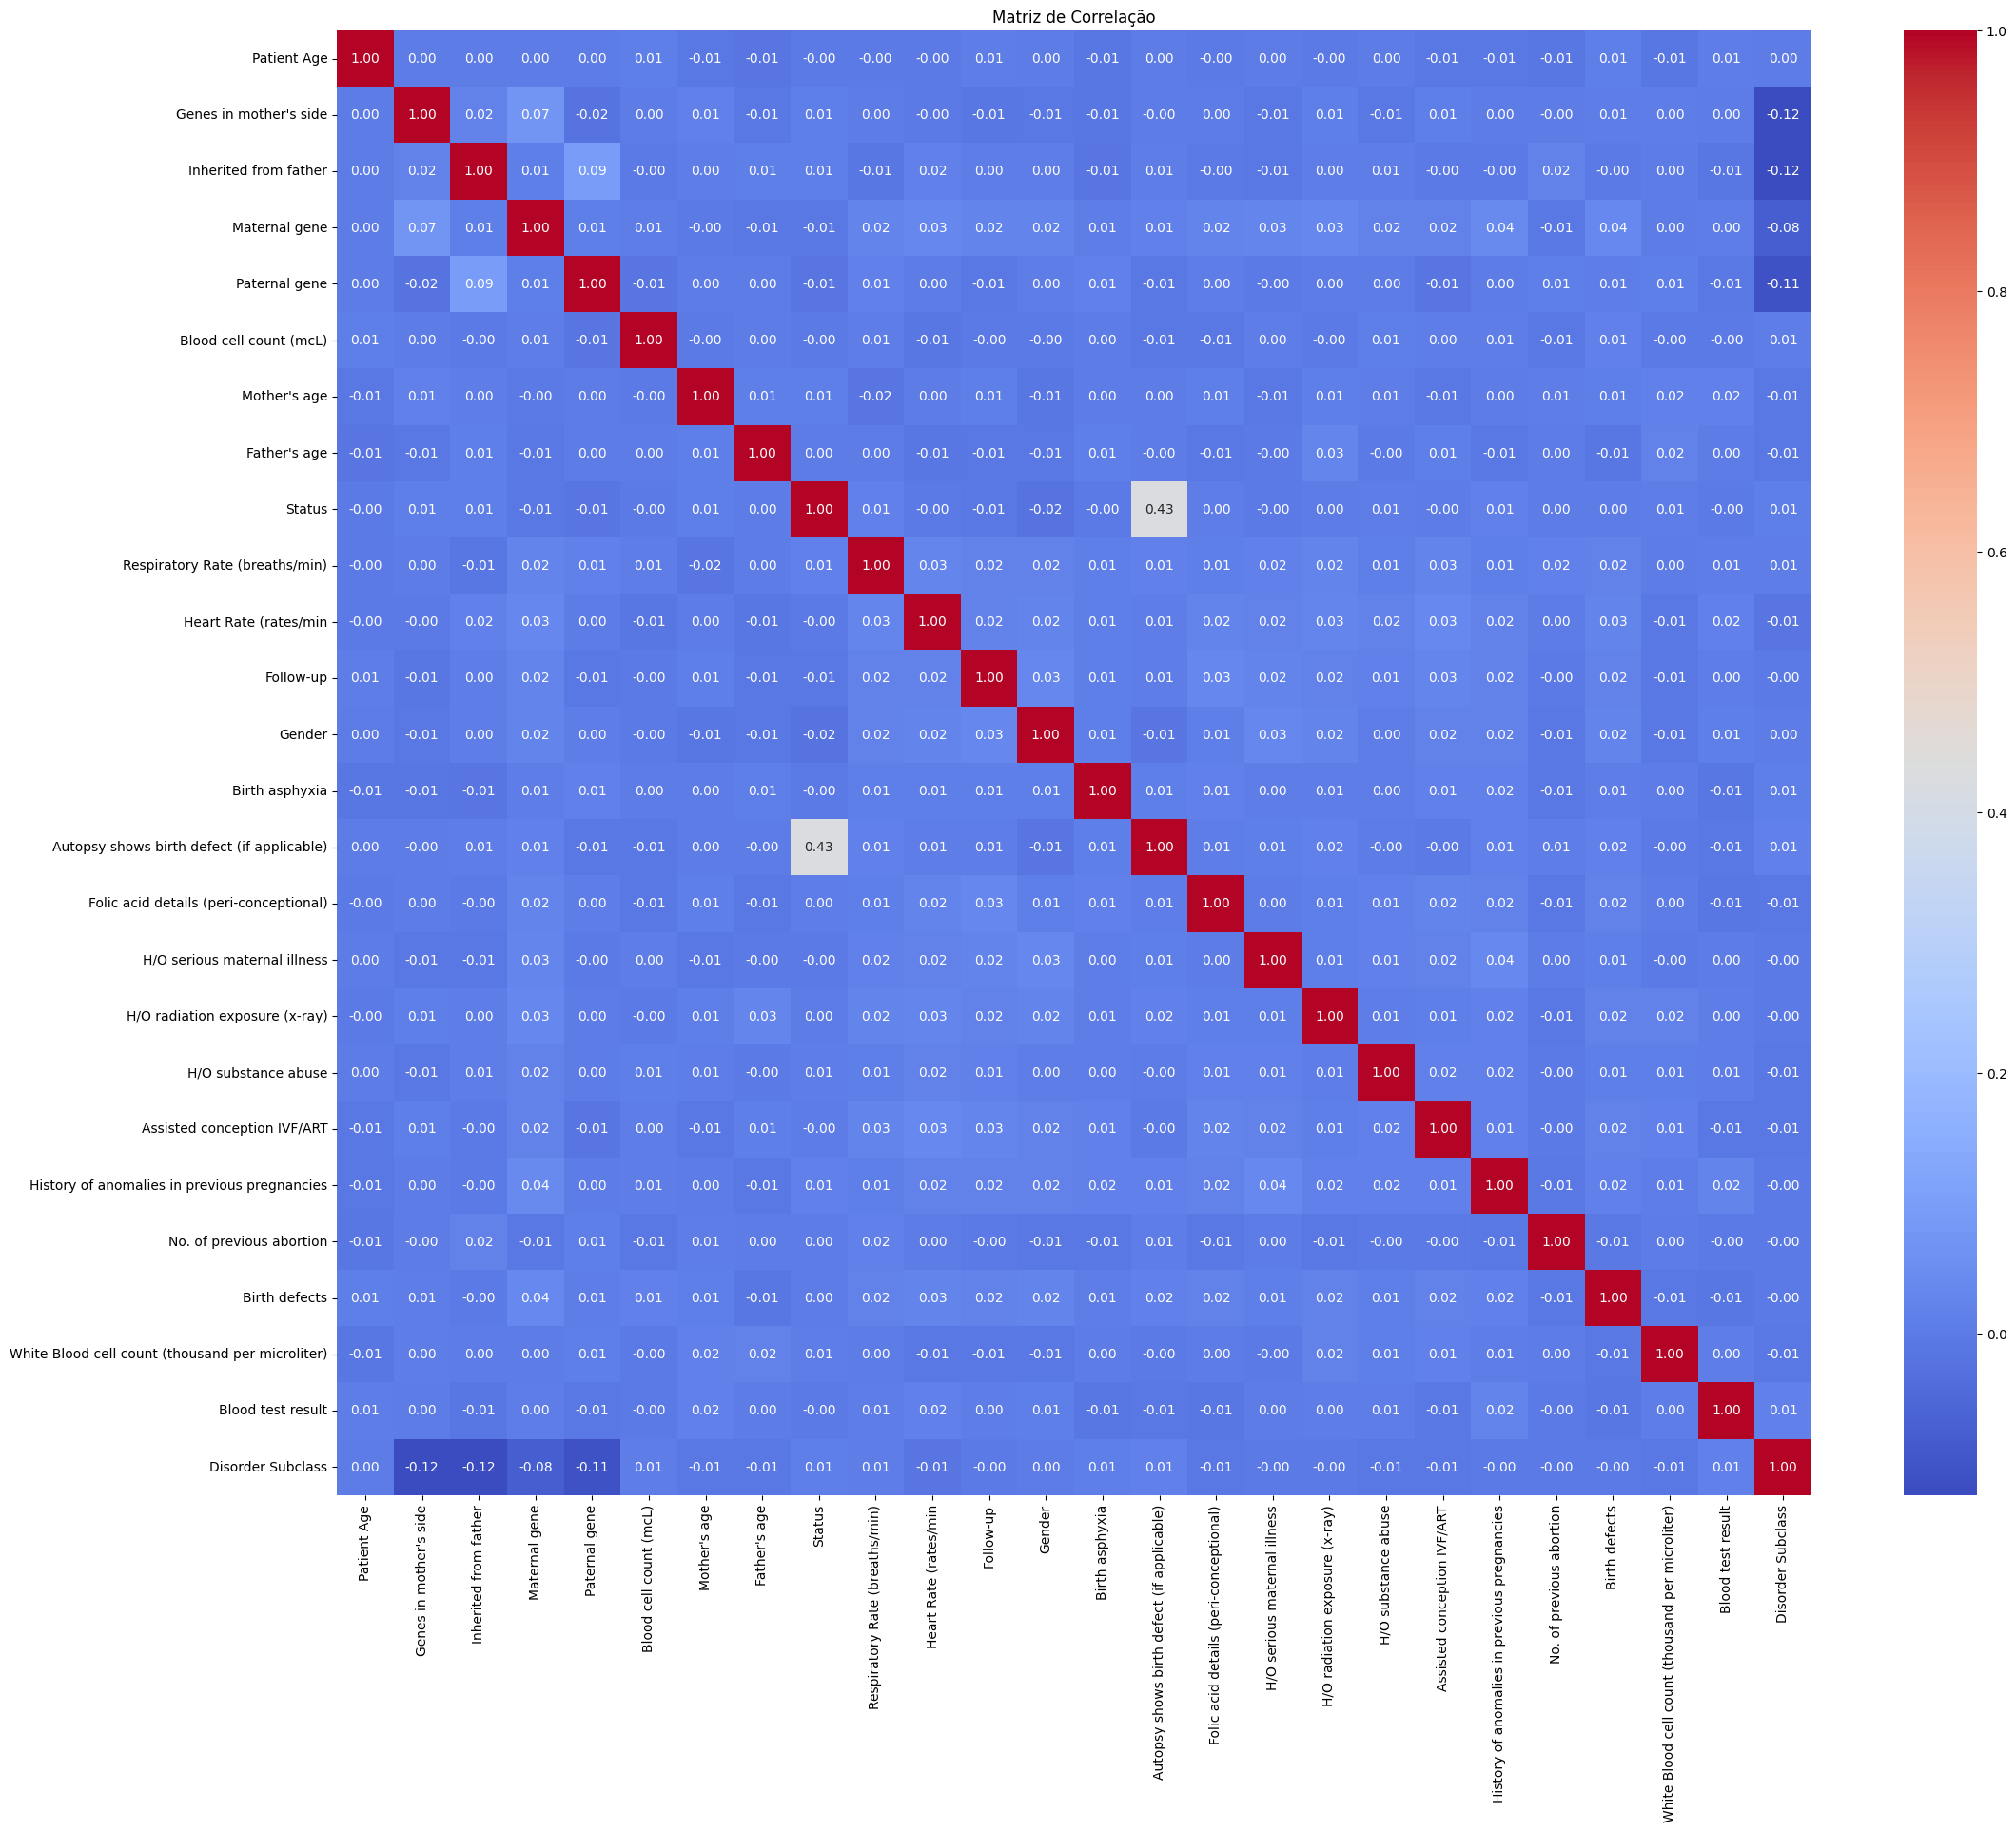

In [ ]:

label_encoders = {}

sample_corr = sample.copy()
for column in sample_corr.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    sample_corr[column] = label_encoders[column].fit_transform(sample_corr[column].astype(str))

corr_matrix = sample_corr.corr(method="pearson")
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

## Variáveis numéricas

In [ ]:
num_cols = sample.select_dtypes(include=['number']).columns.tolist()

In [ ]:
num_cols

['Patient Age',
 'Blood cell count (mcL)',
 "Mother's age",
 "Father's age",
 'No. of previous abortion',
 'White Blood cell count (thousand per microliter)']

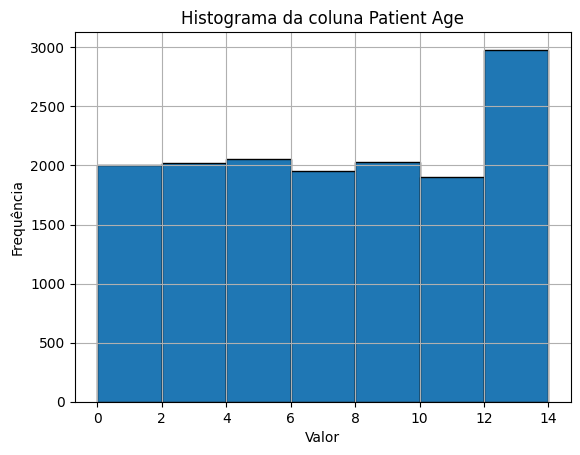

In [ ]:
sample['Patient Age'].hist(bins=7, edgecolor='black')
plt.title('Histograma da coluna Patient Age')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

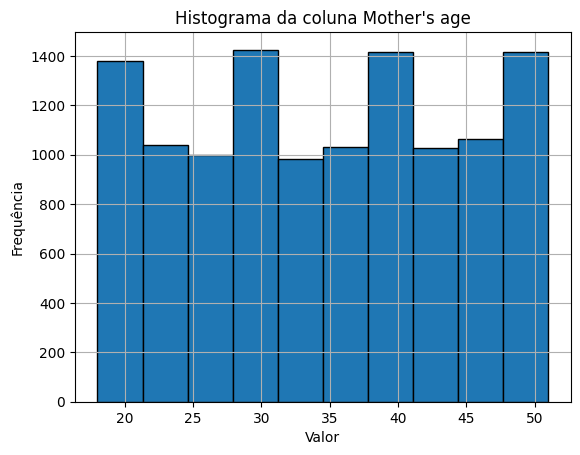

In [ ]:
sample['Mother\'s age'].hist(bins=10, edgecolor='black')
plt.title("Histograma da coluna Mother's age")
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

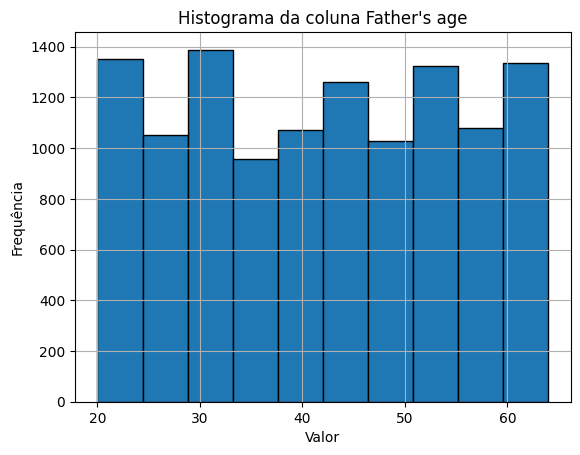

In [ ]:
sample['Father\'s age'].hist(bins=10, edgecolor='black')
plt.title("Histograma da coluna Father's age")
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

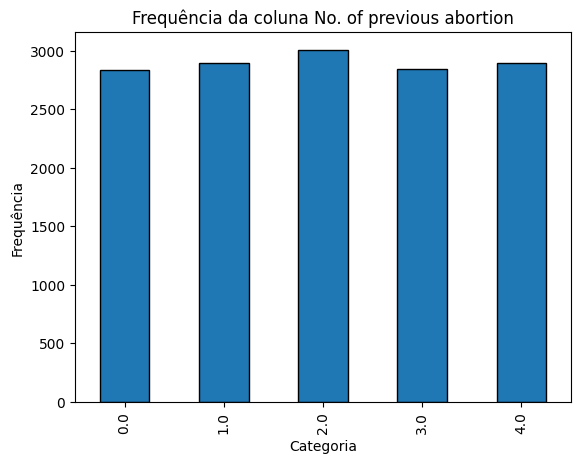

In [ ]:
freq = sample['No. of previous abortion'].value_counts()

freq_sorted = freq.sort_index()

freq_sorted.plot(kind='bar', edgecolor='black')
plt.title('Frequência da coluna No. of previous abortion')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.show()

Text(0, 0.5, 'Densidade')

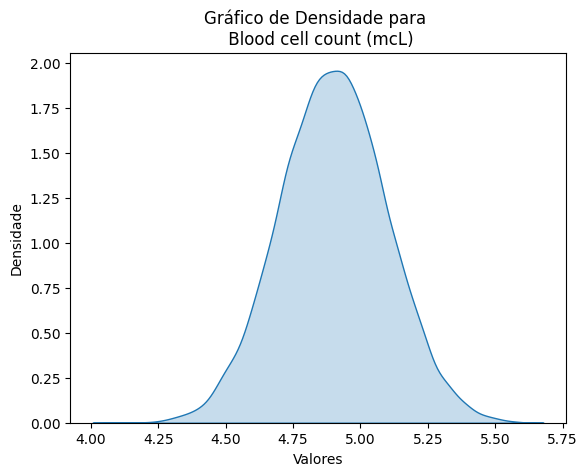

In [ ]:
sns.kdeplot(sample['Blood cell count (mcL)'], fill=True)
plt.title(f'Gráfico de Densidade para \n Blood cell count (mcL)')
plt.xlabel('Valores')
plt.ylabel('Densidade')

Text(0, 0.5, 'Densidade')

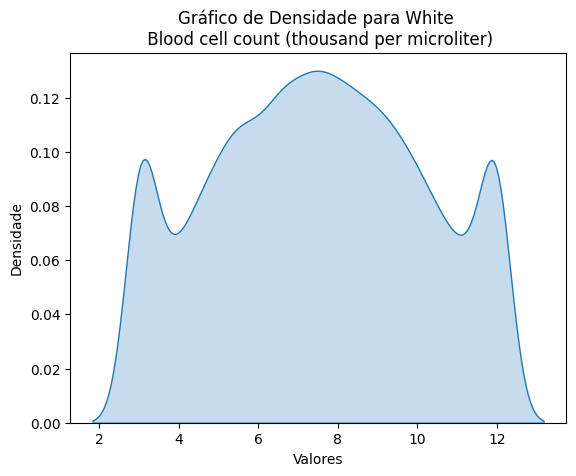

In [ ]:
sns.kdeplot(sample['White Blood cell count (thousand per microliter)'], fill=True)
plt.title(f'Gráfico de Densidade para White \n Blood cell count (thousand per microliter)')
plt.xlabel('Valores')
plt.ylabel('Densidade')

In [ ]:
sample.reset_index(drop=True, inplace=True)

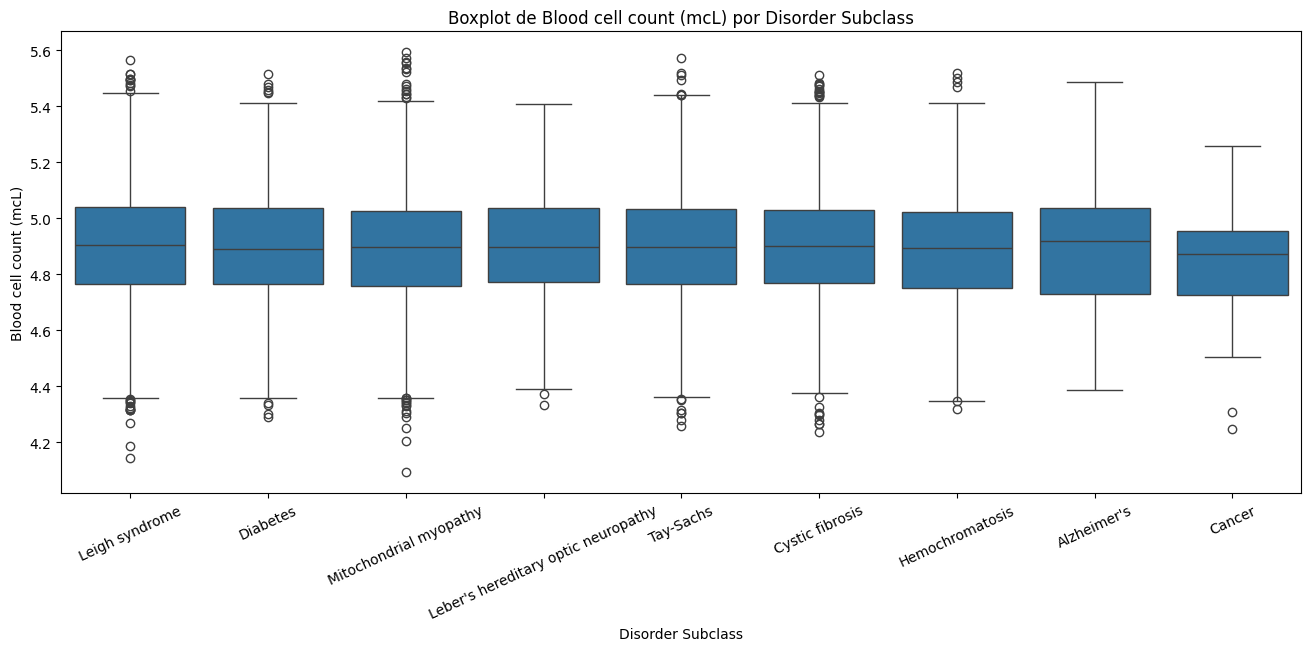

In [ ]:
# Criar o boxplot de Blood cell count (mcL) para cada classe de Disorder Subclass
plt.figure(figsize=(16, 6))
sns.boxplot(x='Disorder Subclass', y='Blood cell count (mcL)', data=sample)
plt.title('Boxplot de Blood cell count (mcL) por Disorder Subclass')
plt.xlabel('Disorder Subclass')
plt.ylabel('Blood cell count (mcL)')
plt.xticks(rotation=25)  # Rotacionar os rótulos do eixo x para melhor visualização
plt.show()

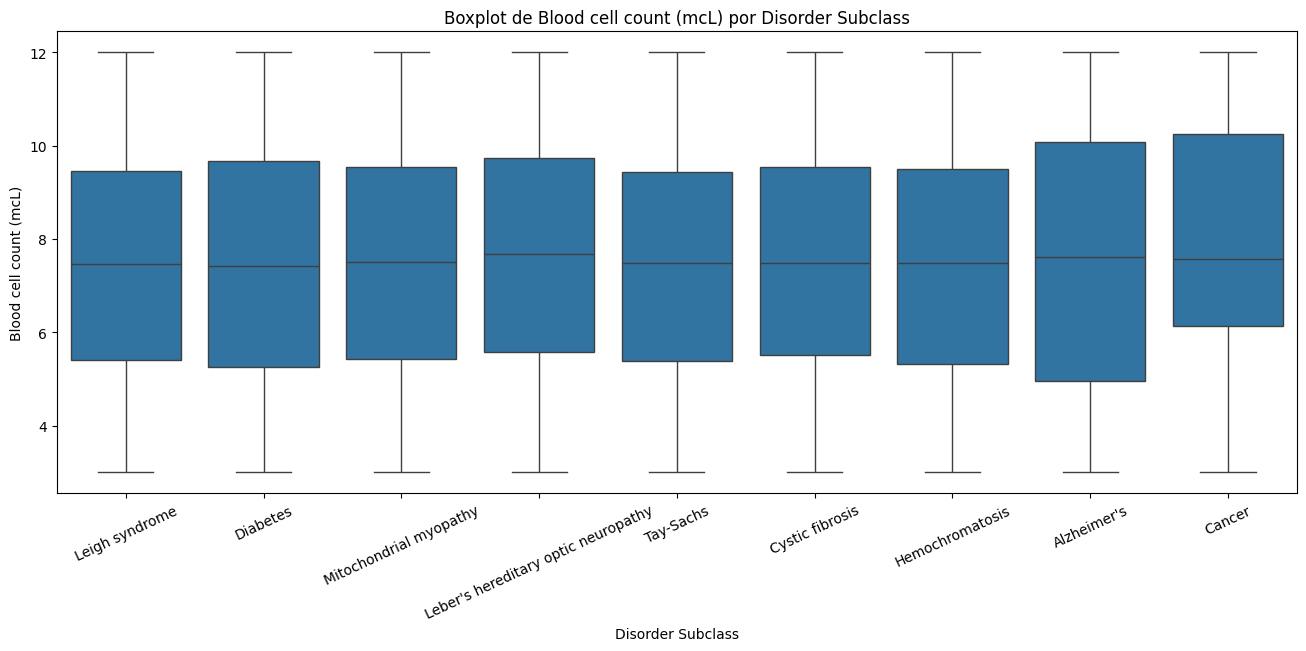

In [ ]:
# Criar o boxplot de Blood cell count (mcL) para cada classe de Disorder Subclass
plt.figure(figsize=(16, 6))
sns.boxplot(x='Disorder Subclass', y='White Blood cell count (thousand per microliter)', data=sample)
plt.title('Boxplot de Blood cell count (mcL) por Disorder Subclass')
plt.xlabel('Disorder Subclass')
plt.ylabel('Blood cell count (mcL)')
plt.xticks(rotation=25)  # Rotacionar os rótulos do eixo x para melhor visualização
plt.show()

In [ ]:
# Análise da distribuição de cada disorder subclass com presença de gene com defeito de pai e mãe
sample[['Maternal gene', 'Paternal gene', 'Disorder Subclass']].value_counts()

cross_tab = pd.crosstab(index=[sample['Maternal gene'], sample['Paternal gene']], columns=sample['Disorder Subclass'])
cross_tab.T

Maternal gene                         No        Yes     
Paternal gene                         No  Yes    No  Yes
Disorder Subclass                                       
Alzheimer's                            9   19    23   59
Cancer                                44    8    14    1
Cystic fibrosis                      406  452   764  801
Diabetes                             175  230   431  438
Hemochromatosis                      398  185   270  108
Leber's hereditary optic neuropathy   48   73   121  214
Leigh syndrome                       909  685  1155  886
Mitochondrial myopathy               943  615   965  561
Tay-Sachs                            702  389   580  312

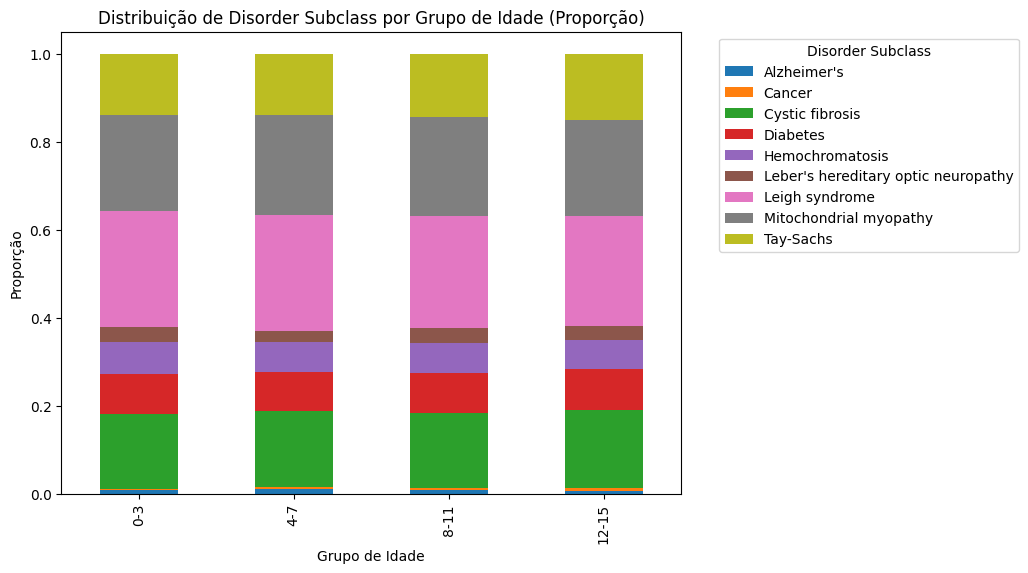

In [ ]:
# Proporção dos disorder subclass por bins de idade
age_bins = [0, 3, 7, 11, 15]
age_labels = ['0-3', '4-7', '8-11', '12-15']
sample['age_group'] = pd.cut(sample['Patient Age'], bins=age_bins, labels=age_labels)

age_disorder_counts = sample.groupby(['age_group', 'Disorder Subclass']).size().unstack(fill_value=0)
age_disorder_proportions = age_disorder_counts.div(age_disorder_counts.sum(axis=1), axis=0)

age_disorder_proportions.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribuição de Disorder Subclass por Grupo de Idade (Proporção)')
plt.ylabel('Proporção')
plt.xlabel('Grupo de Idade')
plt.legend(title='Disorder Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:

sample.pop('age_group')

0          4-7
1          0-3
2         8-11
3        12-15
4          4-7
         ...  
15927      4-7
15928     8-11
15929      NaN
15930    12-15
15931      4-7
Name: age_group, Length: 15932, dtype: category
Categories (4, object): ['0-3' < '4-7' < '8-11' < '12-15']

## Variáveis categóricas

In [ ]:
cat_cols = sample.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

["Genes in mother's side",
 'Inherited from father',
 'Maternal gene',
 'Paternal gene',
 'Status',
 'Respiratory Rate (breaths/min)',
 'Heart Rate (rates/min',
 'Follow-up',
 'Gender',
 'Birth asphyxia',
 'Autopsy shows birth defect (if applicable)',
 'Folic acid details (peri-conceptional)',
 'H/O serious maternal illness',
 'H/O radiation exposure (x-ray)',
 'H/O substance abuse',
 'Assisted conception IVF/ART',
 'History of anomalies in previous pregnancies',
 'Birth defects',
 'Blood test result',
 'Disorder Subclass']

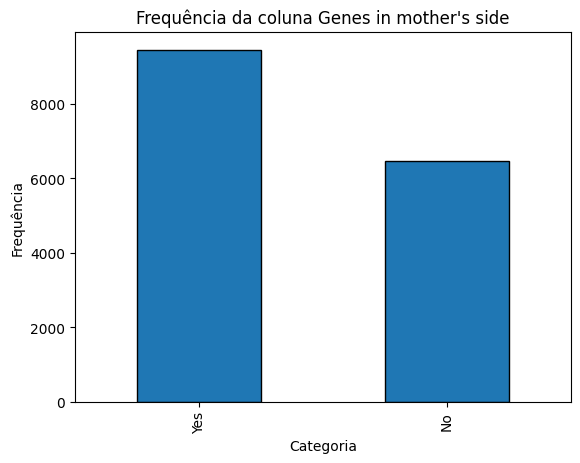

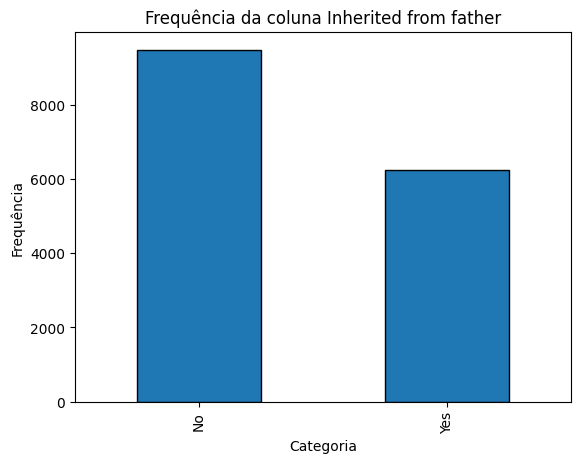

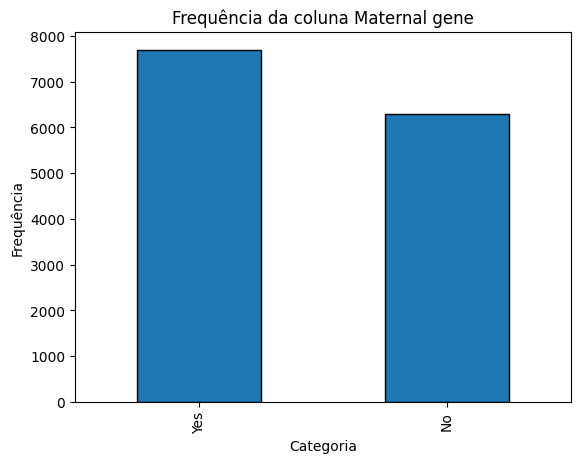

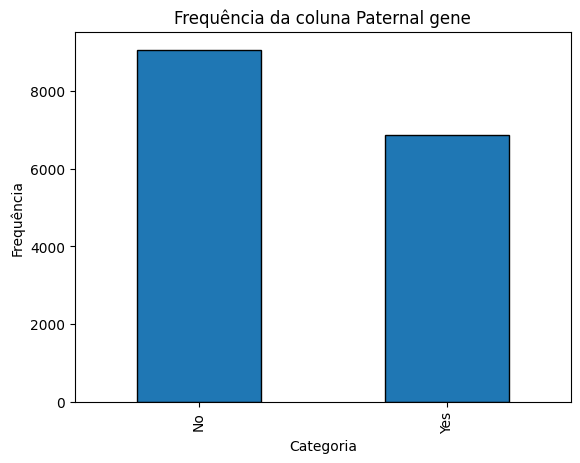

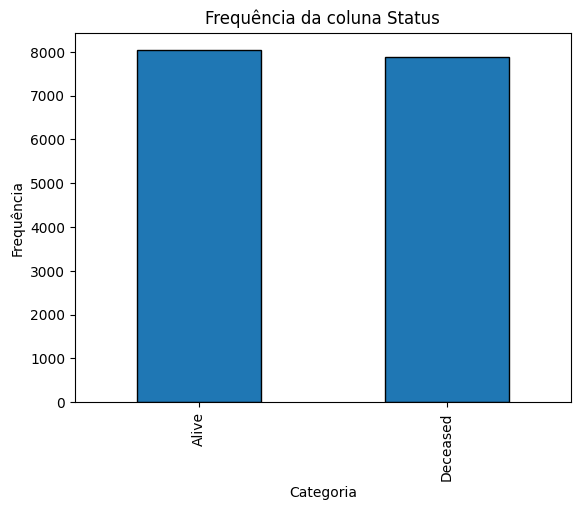

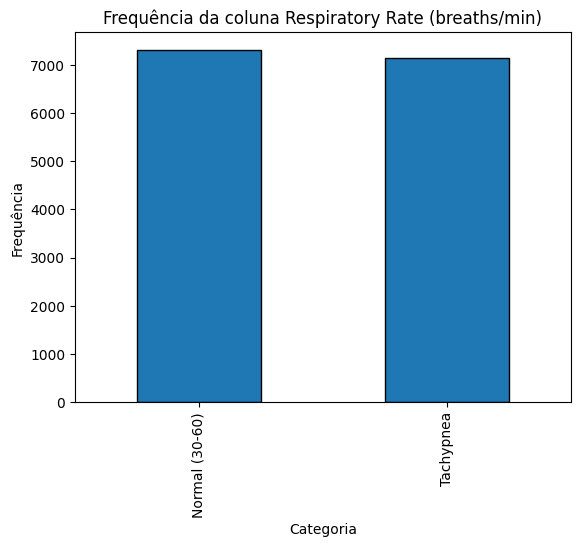

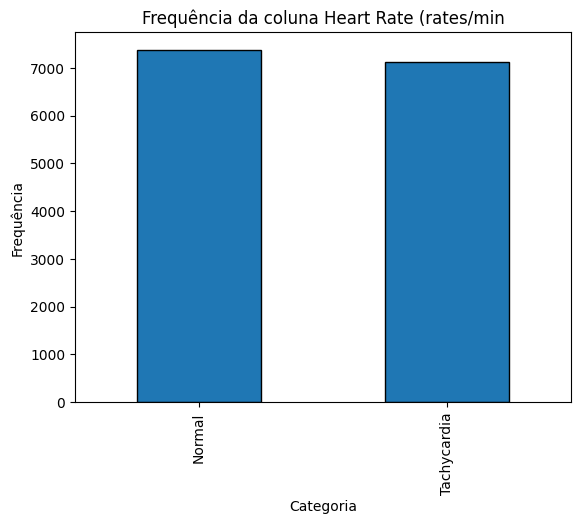

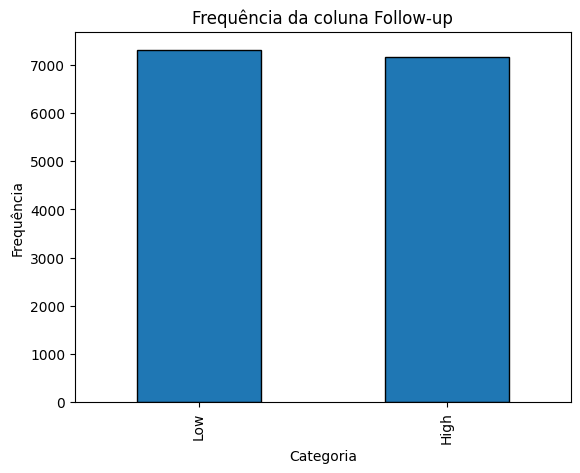

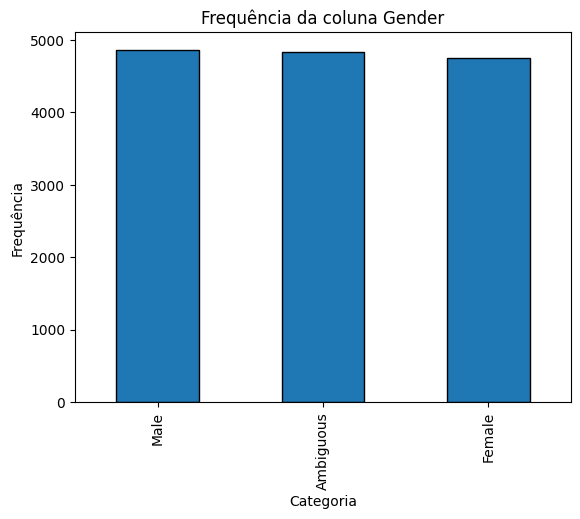

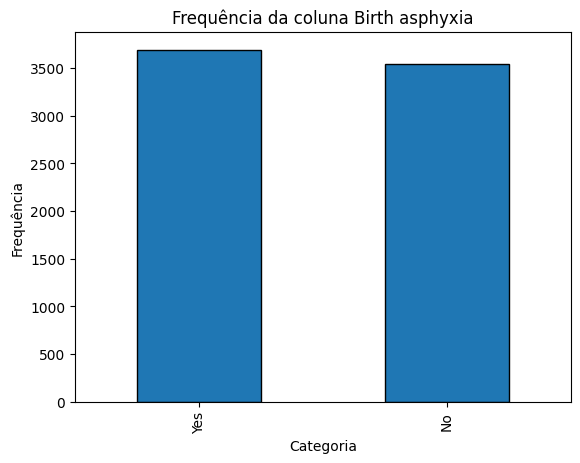

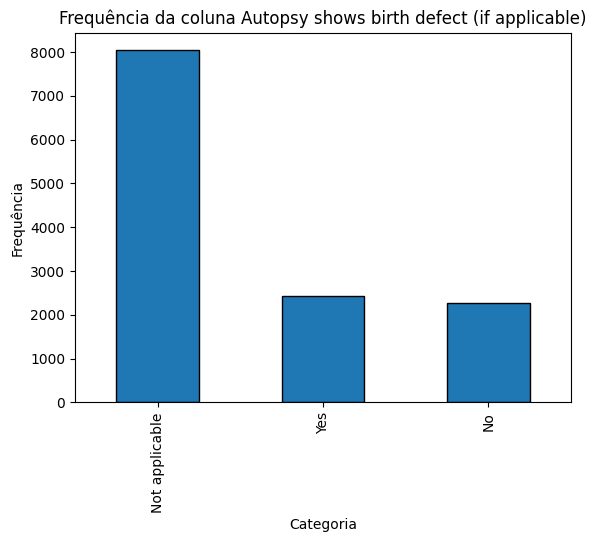

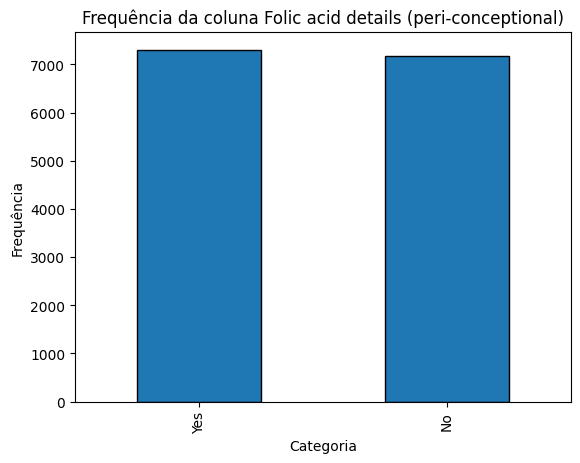

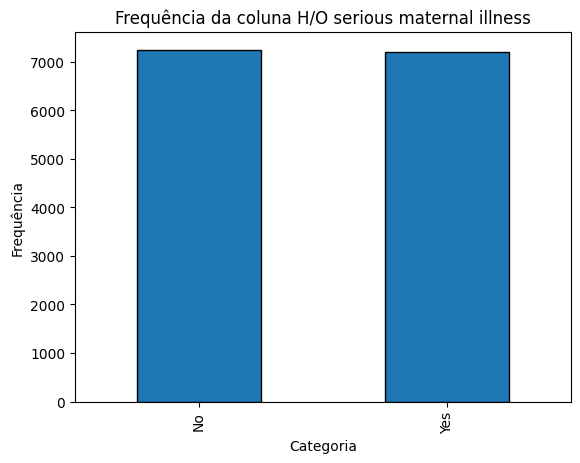

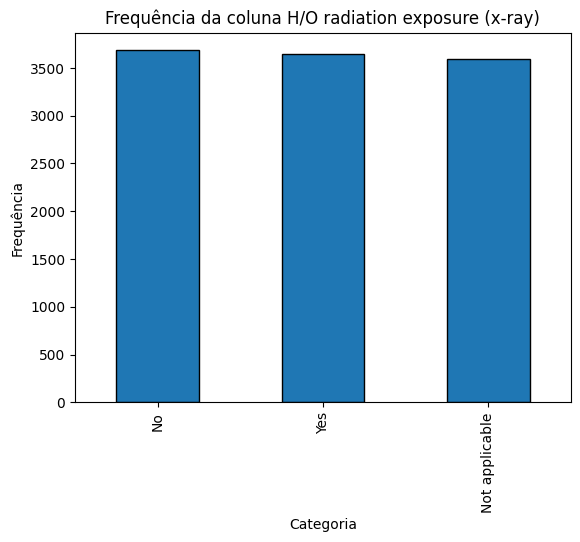

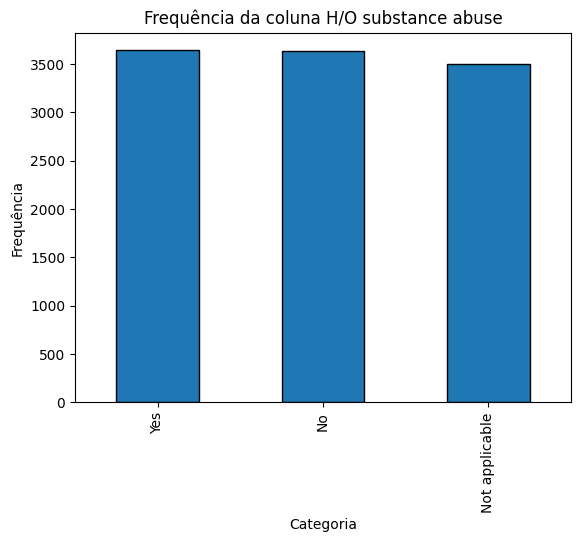

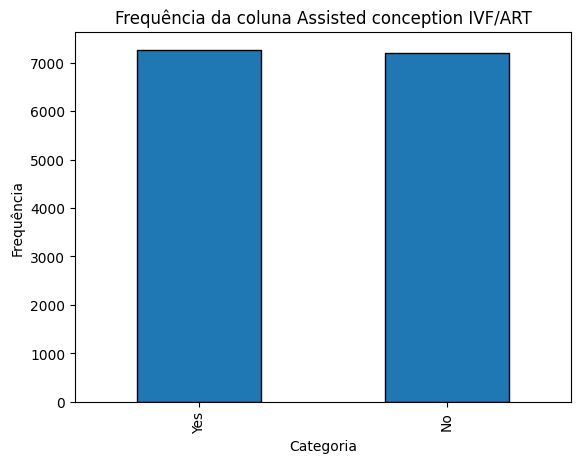

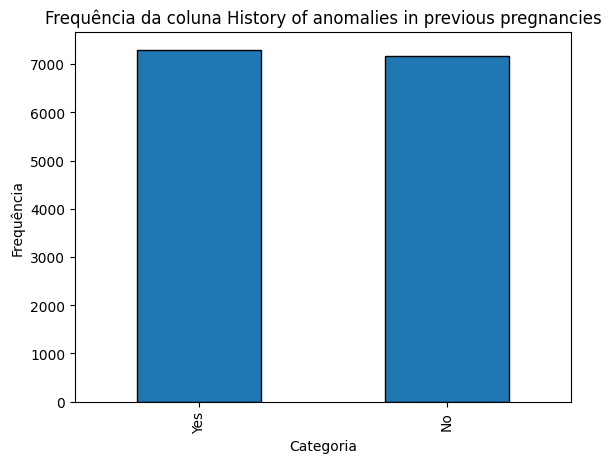

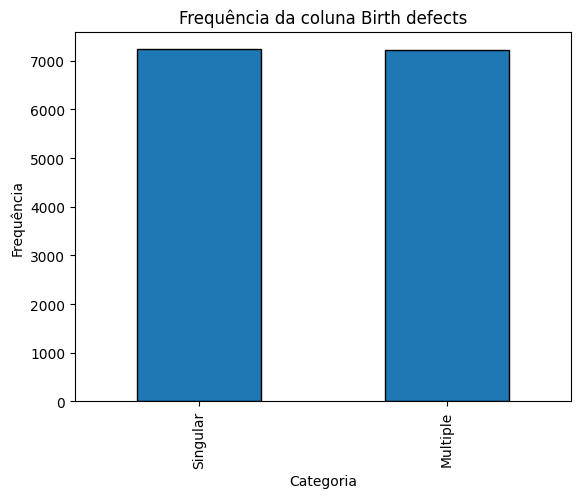

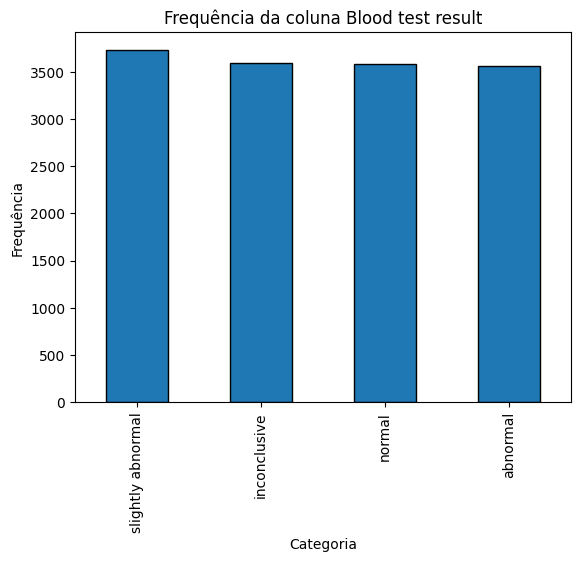

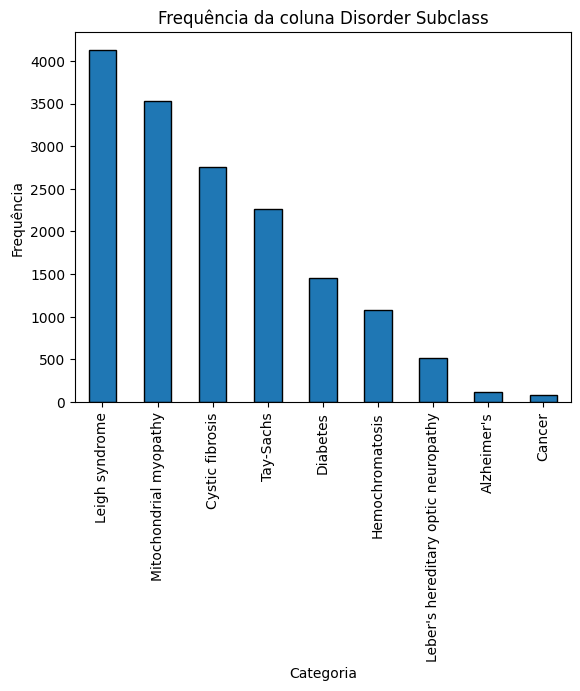

In [ ]:
for col in cat_cols:
  freq = sample[col].value_counts()
  freq.plot(kind='bar', edgecolor='black')
  plt.title(f'Frequência da coluna {col}')
  plt.xlabel('Categoria')
  plt.ylabel('Frequência')
  plt.show()

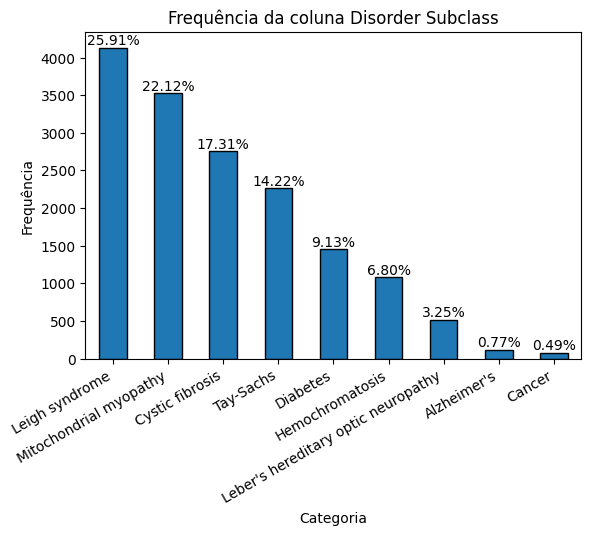

In [ ]:
freq = sample['Disorder Subclass'].value_counts()

percentages = (freq / freq.sum()) * 100

ax = freq.plot(kind='bar', edgecolor='black')

plt.title(f'Frequência da coluna Disorder Subclass')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.gcf().autofmt_xdate()

for i in ax.containers:
    ax.bar_label(i, labels=[f'{p:.2f}%' for p in percentages], label_type='edge')

plt.show()

In [ ]:
all_cols = sample.columns.tolist()

In [ ]:
len(all_cols) == len(num_cols) + len(cat_cols)

True

# Pré-processamento

# Análise de dados nulos

In [ ]:
modeling_data = modeling_data.drop(rem_cols, axis=1)
modeling_data.head(2)

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),...,H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Disorder Subclass
0,2.0,Yes,No,Yes,No,4.760603,NaN,NaN,Alive,Normal (30-60),...,NaN,No,No,No,Yes,NaN,NaN,9.857562,NaN,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,NaN,23.0,Deceased,Tachypnea,...,Yes,Not applicable,Not applicable,No,Yes,NaN,Multiple,5.522560,normal,Cystic fibrosis


In [ ]:
# Verificar se existe algum valor -99 ou '-99'
existe_neg_99 = ((modeling_data == -99) | (modeling_data == '-99')).any().any()

if existe_neg_99:
    print("Existem células com o valor -99 ou '-99' no DataFrame.")
else:
    print("Não existem células com o valor -99 ou '-99' no DataFrame.")

Não existem células com o valor -99 ou '-99' no DataFrame.


In [ ]:
modeling_data.replace('-', np.nan, inplace=True)
modeling_data.replace('Not available', np.nan, inplace=True)
modeling_data.replace('No record', np.nan, inplace=True)

In [ ]:
modeling_data.shape

(19915, 26)

In [ ]:
# Dividir o dataset em conjunto de treino (80%) e conjunto temporário (20%)
df_train, df_test = train_test_split(modeling_data, train_size=0.8, random_state=seed, stratify = modeling_data["Disorder Subclass"])

# # Dividir o conjunto temporário em conjunto de validação (50% de 20% = 10%) e conjunto de teste (50% de 20% = 10%)
# df_val, df_test = train_test_split(df_temp, train_size=0.5, random_state=seed)

In [ ]:
# Exibir o tamanho dos conjuntos de treino, validação e teste
print("Tamanho do conjunto de treino:", df_train.shape)
#print("Tamanho do conjunto de validação:", df_val.shape)
print("Tamanho do conjunto de teste:", df_test.shape)

Tamanho do conjunto de treino: (15932, 26)
Tamanho do conjunto de teste: (3983, 26)


In [ ]:
modeling_data.isnull().mean() * 100

Patient Age                                          6.241526
Genes in mother's side                               0.000000
Inherited from father                                1.320613
Maternal gene                                       12.076324
Paternal gene                                        0.000000
Blood cell count (mcL)                               0.000000
Mother's age                                        26.090886
Father's age                                        25.704243
Status                                               0.000000
Respiratory Rate (breaths/min)                       9.324630
Heart Rate (rates/min                                8.978157
Follow-up                                            9.264374
Gender                                               9.354758
Birth asphyxia                                      54.506653
Autopsy shows birth defect (if applicable)          19.874466
Folic acid details (peri-conceptional)               9.153904
H/O seri

In [ ]:
df_train.isnull().sum()

Patient Age                                          994
Genes in mother's side                                 0
Inherited from father                                211
Maternal gene                                       1939
Paternal gene                                          0
Blood cell count (mcL)                                 0
Mother's age                                        4152
Father's age                                        4081
Status                                                 0
Respiratory Rate (breaths/min)                      1473
Heart Rate (rates/min                               1428
Follow-up                                           1450
Gender                                              1490
Birth asphyxia                                      8692
Autopsy shows birth defect (if applicable)          3196
Folic acid details (peri-conceptional)              1442
H/O serious maternal illness                        1484
H/O radiation exposure (x-ray) 

In [ ]:
df_train.isnull().mean() * 100

Patient Age                                          6.239016
Genes in mother's side                               0.000000
Inherited from father                                1.324379
Maternal gene                                       12.170475
Paternal gene                                        0.000000
Blood cell count (mcL)                               0.000000
Mother's age                                        26.060758
Father's age                                        25.615114
Status                                               0.000000
Respiratory Rate (breaths/min)                       9.245544
Heart Rate (rates/min                                8.963093
Follow-up                                            9.101180
Gender                                               9.352247
Birth asphyxia                                      54.556867
Autopsy shows birth defect (if applicable)          20.060256
Folic acid details (peri-conceptional)               9.050967
H/O seri

In [ ]:
df_train.isnull().mean().mean() * 100

12.313389598099615

In [ ]:
sample.isnull().mean() * 100

Patient Age                                          6.239016
Genes in mother's side                               0.000000
Inherited from father                                1.324379
Maternal gene                                       12.170475
Paternal gene                                        0.000000
Blood cell count (mcL)                               0.000000
Mother's age                                        26.060758
Father's age                                        25.615114
Status                                               0.000000
Respiratory Rate (breaths/min)                       9.245544
Heart Rate (rates/min                                8.963093
Follow-up                                            9.101180
Gender                                               9.352247
Birth asphyxia                                      54.556867
Autopsy shows birth defect (if applicable)          20.060256
Folic acid details (peri-conceptional)               9.050967
H/O seri

In [ ]:
sample.isnull().mean().mean()

0.12313389598099615

# Tratamento de dados nulos

In [ ]:
df_train_num_cols = df_train.select_dtypes(include=['number']).columns.tolist()
df_train_num_cols

['Patient Age',
 'Blood cell count (mcL)',
 "Mother's age",
 "Father's age",
 'No. of previous abortion',
 'White Blood cell count (thousand per microliter)']

In [ ]:
# # Substituir os valores nulos das variáveis numéricas pela média dos valores dos outros pacientes que possuem mesma disorder subclass
# for col in df_train_num_cols:
#   df_train[col] = df_train.groupby(['Disorder Subclass'])[col].transform(lambda x: x.fillna(x.mean()))

# # Substituir os valores nulos das variáveis numéricas pela média dos valores dos outros pacientes que possuem mesma disorder subclass
# for col in df_train_num_cols:
#   df_test[col] = df_test.groupby(['Disorder Subclass'])[col].transform(lambda x: x.fillna(df_train[col].mean()))

In [ ]:
# Substituir os valores nulos das variáveis numéricas pela média dos valores dos outros pacientes que possuem mesma disorder subclass
for col in df_train_num_cols:
  df_train[col].fillna(df_train[col].median(), inplace=True)

# Substituir os valores nulos das variáveis numéricas pela média dos valores dos outros pacientes que possuem mesma disorder subclass
for col in df_train_num_cols:
  df_test[col].fillna(df_train[col].median(), inplace=True)

In [ ]:
df_train_cat_cols = sample.select_dtypes(include=['object', 'category']).columns.tolist()
df_train_cat_cols

["Genes in mother's side",
 'Inherited from father',
 'Maternal gene',
 'Paternal gene',
 'Status',
 'Respiratory Rate (breaths/min)',
 'Heart Rate (rates/min',
 'Follow-up',
 'Gender',
 'Birth asphyxia',
 'Autopsy shows birth defect (if applicable)',
 'Folic acid details (peri-conceptional)',
 'H/O serious maternal illness',
 'H/O radiation exposure (x-ray)',
 'H/O substance abuse',
 'Assisted conception IVF/ART',
 'History of anomalies in previous pregnancies',
 'Birth defects',
 'Blood test result',
 'Disorder Subclass']

In [ ]:
# Substituir os valores nulos das variáveis categóricas pela moda dos valores
for col in df_train_cat_cols:
  df_train[col].fillna(df_train[col].mode()[0], inplace=True)


# Substituir os valores nulos das variáveis categóricas pela moda dos valores
for col in df_train_cat_cols:
  df_test[col].fillna(df_train[col].mode()[0], inplace=True)

In [ ]:
df_train.isnull().sum()

Patient Age                                         0
Genes in mother's side                              0
Inherited from father                               0
Maternal gene                                       0
Paternal gene                                       0
Blood cell count (mcL)                              0
Mother's age                                        0
Father's age                                        0
Status                                              0
Respiratory Rate (breaths/min)                      0
Heart Rate (rates/min                               0
Follow-up                                           0
Gender                                              0
Birth asphyxia                                      0
Autopsy shows birth defect (if applicable)          0
Folic acid details (peri-conceptional)              0
H/O serious maternal illness                        0
H/O radiation exposure (x-ray)                      0
H/O substance abuse         

# Modelo

### Teste inicial

In [ ]:
y_train = df_train['Disorder Subclass']
y_test = df_test['Disorder Subclass']
X_train = df_train[[col for col in  df_train.columns if col not in ['Disorder Subclass']]]
X_test = df_test[[col for col in  df_test.columns if col not in ['Disorder Subclass']]]

In [ ]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype not in ["float64"]]

X_train_cat = pd.get_dummies(X_train[cat_cols])
X_test_cat = pd.get_dummies(X_test[cat_cols])

X_train_processed =  pd.concat([X_train_cat, X_train[[col for col in X_train.columns if col not in cat_cols]]], axis =1)
X_test_processed =  pd.concat([X_test_cat, X_test[[col for col in X_test.columns if col not in cat_cols]]], axis =1)

In [ ]:
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
from sklearn.metrics import roc_curve
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

In [ ]:

from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# List of classifiers
clfs = [
    XGBClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    DummyClassifier()
]

# Selector
selector = None#SelectPercentile(percentile = 50)
sampler = None #RandomOverSampler(random_state = 42)#None#SMOTEENN()


# Dictionary to hold classification reports
results = []

# Function to run classification and collect results
def run_classifier(clf):
    steps = [
        ("sampler", sampler),
        ("selector", selector),
        ("estimator", clf)
    ]

    #pipe = Pipeline(steps=steps)
    pipe = ImbPipeline(steps=steps)

    pipe.fit(X_train_processed, y_train_enc)

    y_pred = pipe.predict(X_test_processed)

    y_pred_labeled = le.inverse_transform(y_pred)

    dict_clf_rep = classification_report(y_test, y_pred_labeled, output_dict=True)

    clf_name = clf.__class__.__name__

    if clf_name in ['DecisionTreeClassifier', "RandomForestClassifier", "XGBClassifier"]:
      importances = pipe["estimator"].feature_importances_
    else:
      importances = None

    # Add classifier name to the dictionary
    dict_clf_rep['classifier'] = clf_name
    dict_clf_rep['importances'] = importances
    dict_clf_rep['unprocessed_classification_report'] = str(dict_clf_rep)
    dict_clf_rep['y_test'] = np.array(y_test)
    dict_clf_rep['y_pred'] = np.array(y_pred_labeled)


    return dict_clf_rep

# Run classifiers and collect results
for clf in clfs:
    result = run_classifier(clf)
    results.append(result)

# Convert results to DataFrame
df_results = pd.json_normalize(results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
df_results_inicial_1 = df_results.copy()

In [ ]:
df_results_inicial_1

,accuracy,classifier,importances,unprocessed_classification_report,y_test,y_pred,Alzheimer's.precision,Alzheimer's.recall,Alzheimer's.f1-score,Alzheimer's.support,...,Tay-Sachs.f1-score,Tay-Sachs.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,0.240020,XGBClassifier,"[0.051357035, 0.0, 0.047723766, 0.0, 0.0367708...","{""Alzheimer's"": {'precision': 0.0, 'recall': 0...","[Mitochondrial myopathy, Cystic fibrosis, Tay-...","[Leigh syndrome, Mitochondrial myopathy, Leigh...",0.0,0.0,0.0,30,...,0.174921,567,0.134246,0.129508,0.124219,3983,0.213264,0.240020,0.216974,3983
1,0.234999,RandomForestClassifier,"[0.005402063846190837, 0.00587902910269142, 0....","{""Alzheimer's"": {'precision': 0.0, 'recall': 0...","[Mitochondrial myopathy, Cystic fibrosis, Tay-...","[Leigh syndrome, Leigh syndrome, Leigh syndrom...",0.0,0.0,0.0,30,...,0.122605,567,0.136262,0.119649,0.108636,3983,0.210084,0.234999,0.199418,3983
2,0.191062,DecisionTreeClassifier,"[0.004840779962032362, 0.0, 0.0019105495951935...","{""Alzheimer's"": {'precision': 0.0, 'recall': 0...","[Mitochondrial myopathy, Cystic fibrosis, Tay-...","[Leigh syndrome, Cystic fibrosis, Leigh syndro...",0.0,0.0,0.0,30,...,0.164727,567,0.125431,0.126030,0.125543,3983,0.194655,0.191062,0.192747,3983
3,0.259101,DummyClassifier,None,"{""Alzheimer's"": {'precision': 0.0, 'recall': 0...","[Mitochondrial myopathy, Cystic fibrosis, Tay-...","[Leigh syndrome, Leigh syndrome, Leigh syndrom...",0.0,0.0,0.0,30,...,0.000000,567,0.028789,0.111111,0.045729,3983,0.067133,0.259101,0.106637,3983


### Hiperparameter tunning

In [ ]:
y_train.value_counts()

Disorder Subclass
Leigh syndrome                         4128
Mitochondrial myopathy                 3524
Cystic fibrosis                        2758
Tay-Sachs                              2266
Diabetes                               1454
Hemochromatosis                        1084
Leber's hereditary optic neuropathy     518
Alzheimer's                             122
Cancer                                   78
Name: count, dtype: int64

In [ ]:
# List of classifiers with hyperparameter grids
clfs = [
    {
        'clf': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'estimator__n_estimators': [50, 100, 150],
            'estimator__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    {
        'clf': RandomForestClassifier(random_state=42),
        'params': {
            'estimator__n_estimators': [50, 100, 150],
            'estimator__max_depth': [None, 10, 20]
        }
    },
    {
        'clf': DecisionTreeClassifier(random_state=42),
        'params': {
            'estimator__max_depth': [None, 10, 20],
            'estimator__min_samples_split': [2, 5, 10]
        }
    }
]

# Selector with hyperparameter grid
selector = SelectPercentile()
selector_params = {
    'selector__percentile': [10, 20, 30, 40, 50]
}

# Dictionary to hold classification reports
results = []

# Function to run classification and collect results
def run_classifier(clf, param_grid):
    steps = [
        ("sampler", None),
        ("selector", selector),
        ("estimator", clf)
    ]

    pipe = Pipeline(steps=steps)
    param_grid.update(selector_params)

    grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring = "f1_macro", verbose = 4)
    grid_search.fit(X_train_processed, y_train_enc)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_processed)

    y_pred_labeled = le.inverse_transform(y_pred)

    dict_clf_rep = classification_report(y_test, y_pred_labeled, output_dict=True)

    importances = best_model.named_steps['estimator'].feature_importances_

    # Add classifier name to the dictionary
    dict_clf_rep['classifier'] = clf.__class__.__name__
    dict_clf_rep['importances'] = importances
    dict_clf_rep['best_params'] = grid_search.best_params_
    dict_clf_rep['unprocessed_classification_report'] = str(dict_clf_rep)
    dict_clf_rep['y_test'] = np.array(y_test)
    dict_clf_rep['y_pred'] = np.array(y_pred_labeled)

    return dict_clf_rep

# Run classifiers and collect results
for clf_dict in clfs:
    clf = clf_dict['clf']
    param_grid = clf_dict['params']
    result = run_classifier(clf, param_grid)
    results.append(result)

# Convert results to DataFrame
df_results = pd.json_normalize(results)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [ ]:
df_results_tunned_1 = df_results.copy()

## Teste inicial - oversampling and undersampling

In [ ]:
# def limit_samples_per_class(X, y, max_samples_per_class):
#     df = pd.concat([X, y], axis=1)
#     sampled_data = []
#     for class_label in y.unique():
#         class_data = df[df[y.name] == class_label]
#         sampled_class_data = class_data.sample(min(len(class_data), max_samples_per_class), random_state=42)
#         sampled_data.append(sampled_class_data)
#     df_sampled = pd.concat(sampled_data)
#     X_sampled = df_sampled.drop(columns=[y.name])
#     y_sampled = df_sampled[y.name]
#     return X_sampled, y_sampled

# y_train_enc_ = pd.Series(y_train_enc)
# y_train_enc_.index = y_train.index

# y_test_enc_ = pd.Series(y_test_enc)
# y_test_enc_.index = y_test.index

# y_train_enc_.name = 'Disorder Subclass'
# y_test_enc_.name = 'Disorder Subclass'

# median_class_samples = int(pd.Series(y_train_enc_).value_counts().median())
# X_train_undersample, y_train_undersample = limit_samples_per_class(X_train_processed, y_train_enc_, median_class_samples)

# sampler = RandomOverSampler(random_state=42)
# X_train_underoversample, y_train_underoversample = sampler.fit_resample(X_train_undersample, y_train_undersample)

## Hiperparameter tunning - oversampling and undersampling

In [ ]:
# # List of classifiers with hyperparameter grids
# clfs = [
#     {
#         'clf': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
#         'params': {
#             'estimator__n_estimators': [500],
#             'estimator__learning_rate': [0.01]
#         }
#     },
#     {
#         'clf': RandomForestClassifier(random_state=42),
#         'params': {
#             'estimator__n_estimators': [500]
#         }
#     },
#     {
#         'clf': DecisionTreeClassifier(random_state=42),
#         'params': {
#             'estimator__criterion': ["gini", "entropy", "log_loss"]
#         }
#     }
# ]

# # Selector with hyperparameter grid
# selector = SelectPercentile()
# selector_params = {
#     'selector__percentile': [10, 20, 30, 40, 50]
# }

# # Dictionary to hold classification reports
# results = []

# # Function to run classification and collect results
# def run_classifier(clf, param_grid):
#     steps = [
#         ("sampler", None),
#         ("selector", selector),
#         ("estimator", clf)
#     ]

#     pipe = Pipeline(steps=steps)
#     param_grid.update(selector_params)

#     grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring = "f1_macro")
#     grid_search.fit(X_train_underoversample, y_train_underoversample)

#     best_model = grid_search.best_estimator_

#     y_pred = best_model.predict(X_test_processed)

#     y_pred_labeled = le.inverse_transform(y_pred)

#     dict_clf_rep = classification_report(y_test, y_pred_labeled, output_dict=True)

#     clf_name = clf.__class__.__name__

#     importances = best_model.named_steps['estimator'].feature_importances_

#     # Add classifier name to the dictionary
#     dict_clf_rep['classifier'] = clf_name
#     dict_clf_rep['importances'] = importances
#     dict_clf_rep['unprocessed_classification_report'] = str(dict_clf_rep)
#     dict_clf_rep['y_test'] = np.array(y_test)
#     dict_clf_rep['y_pred'] = np.array(y_pred_labeled)


#     return dict_clf_rep

# # Run classifiers and collect results
# for clf_dict in clfs:
#     clf = clf_dict['clf']
#     param_grid = clf_dict['params']
#     result = run_classifier(clf, param_grid)
#     results.append(result)

# # Convert results to DataFrame
# df_results = pd.json_normalize(results)

# df_results

# from ast import literal_eval
# literal_eval(df_results['unprocessed_classification_report'].unique()[0])

## Análise de Resultados

############################################################
# Modelo: XGBClassifier sem hiperparameter tunning
############################################################
                                     precision    recall  f1-score   support

                        Alzheimer's       0.00      0.00      0.00        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.22      0.21      0.21       690
                           Diabetes       0.13      0.05      0.07       363
                    Hemochromatosis       0.13      0.04      0.06       271
Leber's hereditary optic neuropathy       0.00      0.00      0.00       130
                     Leigh syndrome       0.27      0.43      0.33      1032
             Mitochondrial myopathy       0.25      0.29      0.27       881
                          Tay-Sachs       0.22      0.15      0.17       567

                           accuracy                    

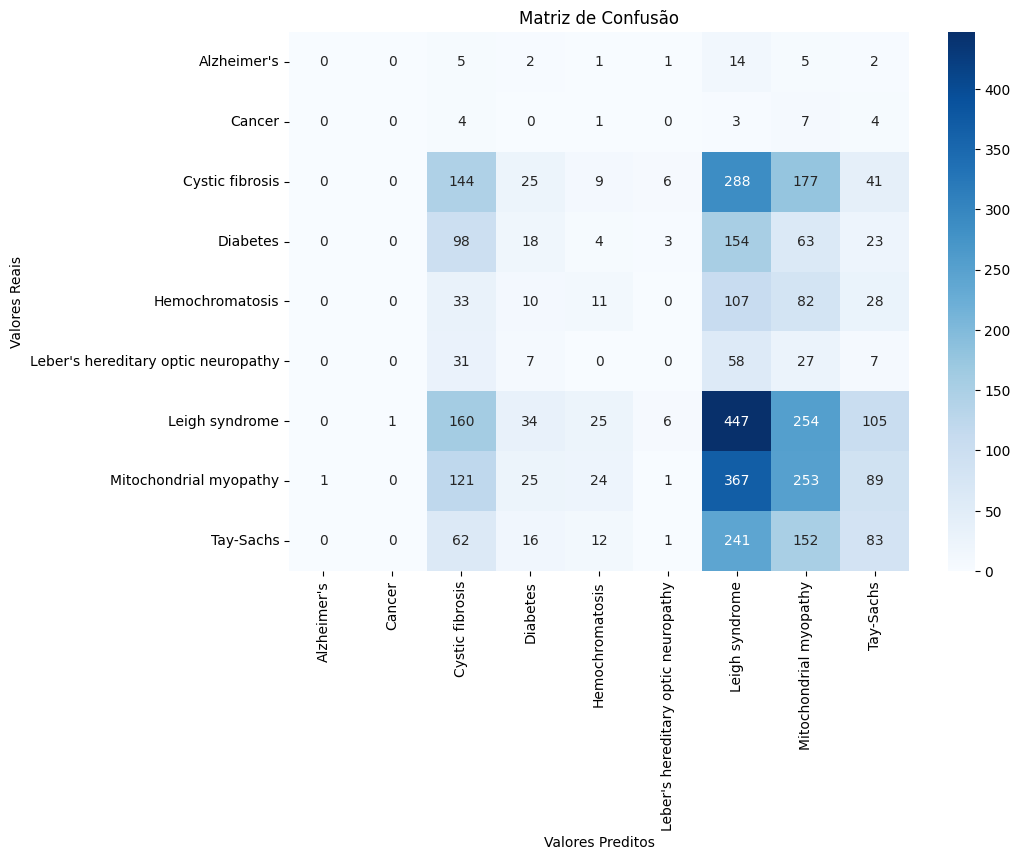

############################################################
# Modelo: RandomForestClassifier sem hiperparameter tunning
############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                                     precision    recall  f1-score   support

                        Alzheimer's       0.00      0.00      0.00        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.20      0.18      0.19       690
                           Diabetes       0.25      0.04      0.07       363
                    Hemochromatosis       0.08      0.01      0.01       271
Leber's hereditary optic neuropathy       0.00      0.00      0.00       130
                     Leigh syndrome       0.25      0.48      0.33      1032
             Mitochondrial myopathy       0.23      0.29      0.26       881
                          Tay-Sachs       0.22      0.08      0.12       567

                           accuracy                           0.23      3983
                          macro avg       0.14      0.12      0.11      3983
                       weighted avg       0.21      0.23      0.20      39

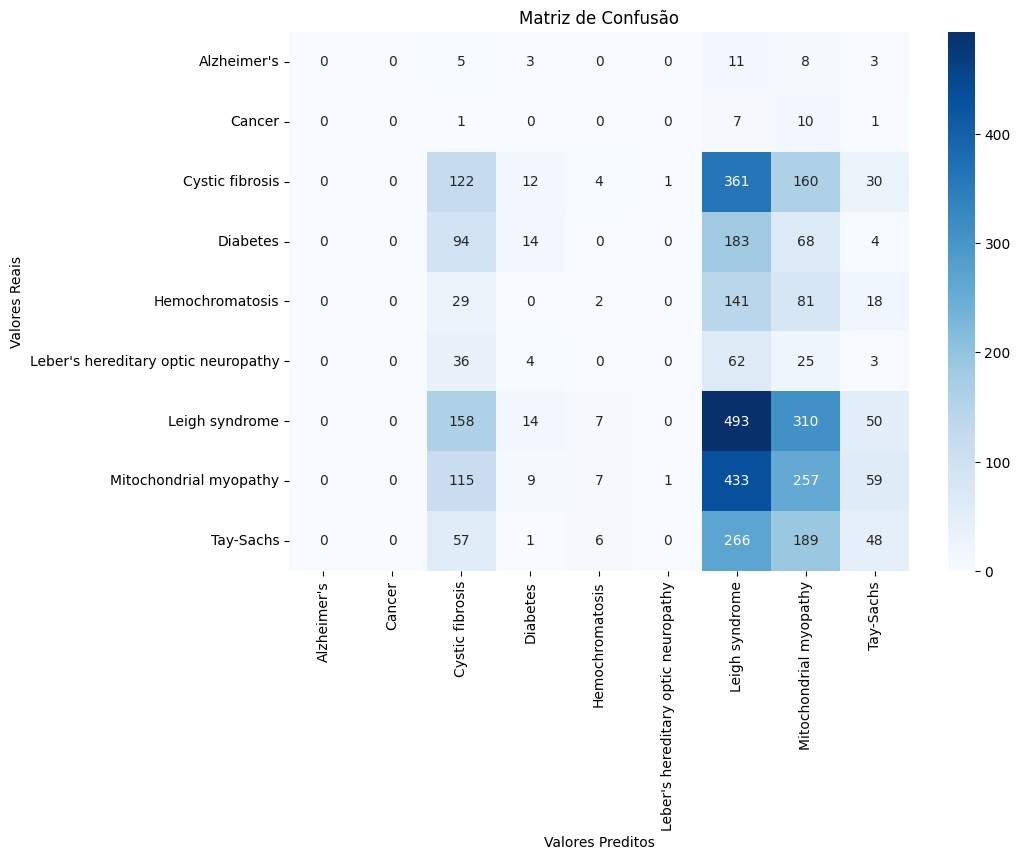

############################################################
# Modelo: DecisionTreeClassifier sem hiperparameter tunning
############################################################
                                     precision    recall  f1-score   support

                        Alzheimer's       0.00      0.00      0.00        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.21      0.20      0.21       690
                           Diabetes       0.13      0.13      0.13       363
                    Hemochromatosis       0.09      0.10      0.09       271
Leber's hereditary optic neuropathy       0.06      0.08      0.07       130
                     Leigh syndrome       0.26      0.25      0.25      1032
             Mitochondrial myopathy       0.21      0.21      0.21       881
                          Tay-Sachs       0.17      0.16      0.16       567

                           accuracy           

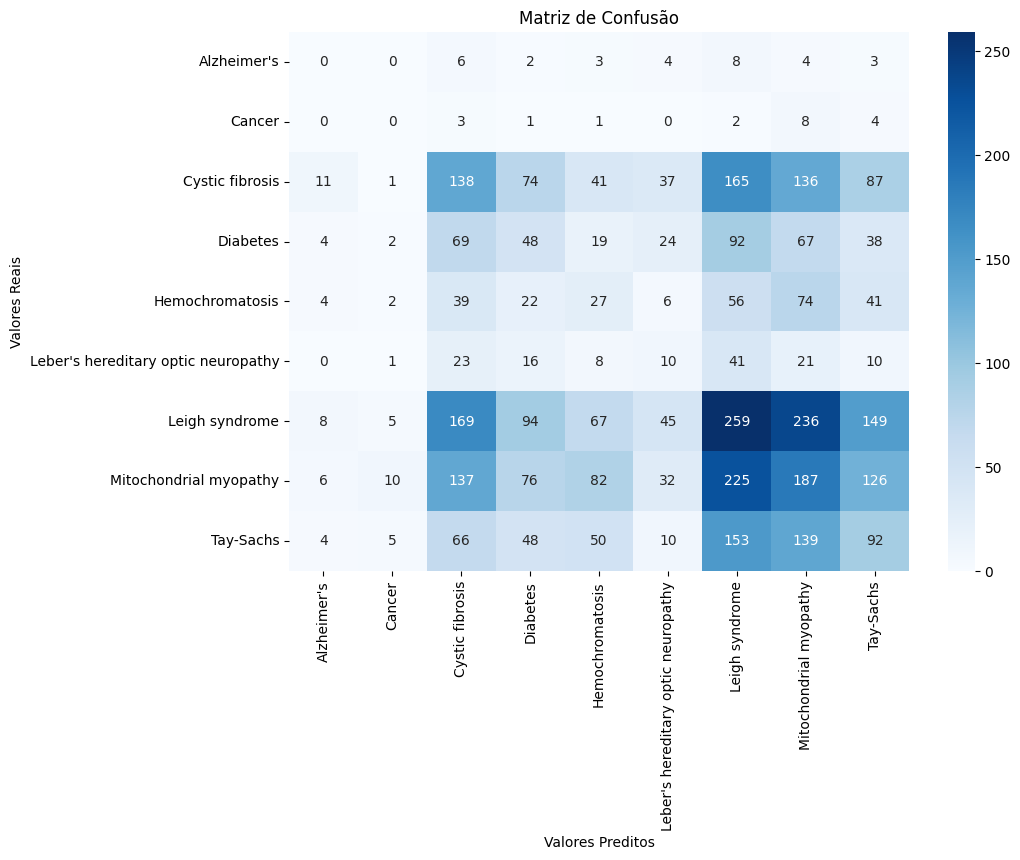

############################################################
# Modelo: DummyClassifier sem hiperparameter tunning
############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                                     precision    recall  f1-score   support

                        Alzheimer's       0.00      0.00      0.00        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.00      0.00      0.00       690
                           Diabetes       0.00      0.00      0.00       363
                    Hemochromatosis       0.00      0.00      0.00       271
Leber's hereditary optic neuropathy       0.00      0.00      0.00       130
                     Leigh syndrome       0.26      1.00      0.41      1032
             Mitochondrial myopathy       0.00      0.00      0.00       881
                          Tay-Sachs       0.00      0.00      0.00       567

                           accuracy                           0.26      3983
                          macro avg       0.03      0.11      0.05      3983
                       weighted avg       0.07      0.26      0.11      39

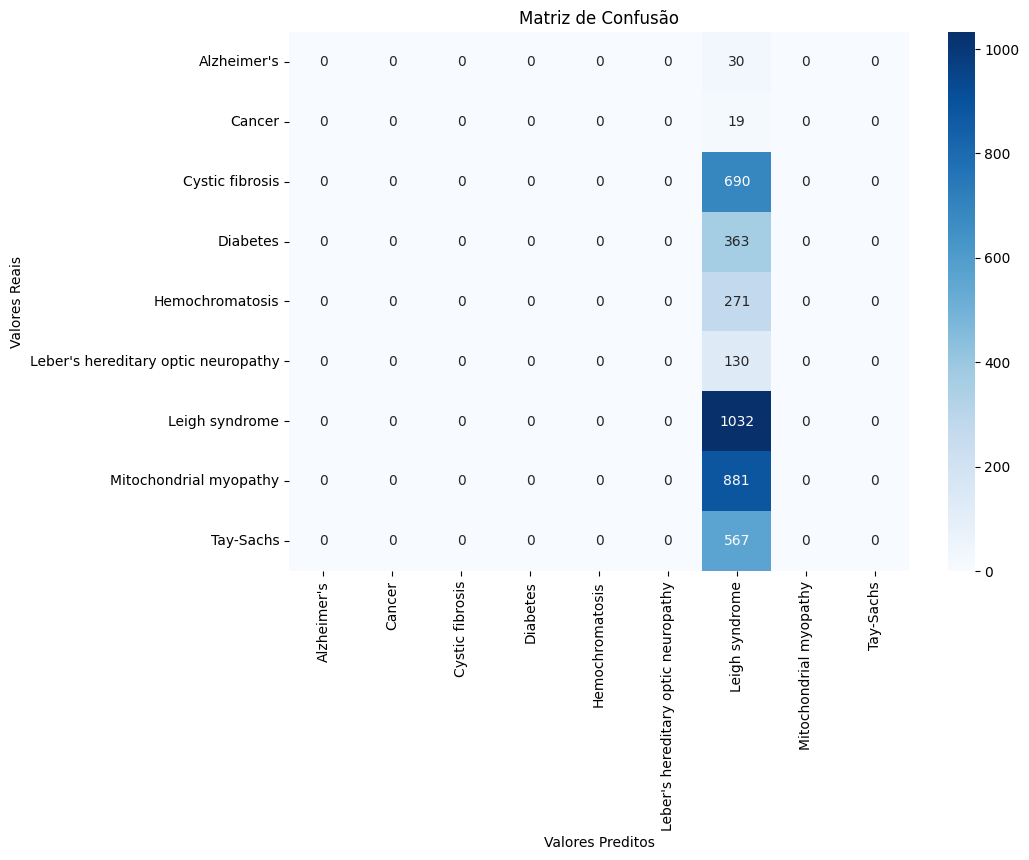










############################################################
# Modelo: XGBClassifier com hiperparameter tunning
############################################################
                                     precision    recall  f1-score   support

                        Alzheimer's       0.00      0.00      0.00        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.21      0.19      0.20       690
                           Diabetes       0.10      0.04      0.06       363
                    Hemochromatosis       0.10      0.03      0.05       271
Leber's hereditary optic neuropathy       0.00      0.00      0.00       130
                     Leigh syndrome       0.26      0.43      0.33      1032
             Mitochondrial myopathy       0.24      0.29      0.27       881
                          Tay-Sachs       0.24      0.14      0.18       567

                           accuracy           

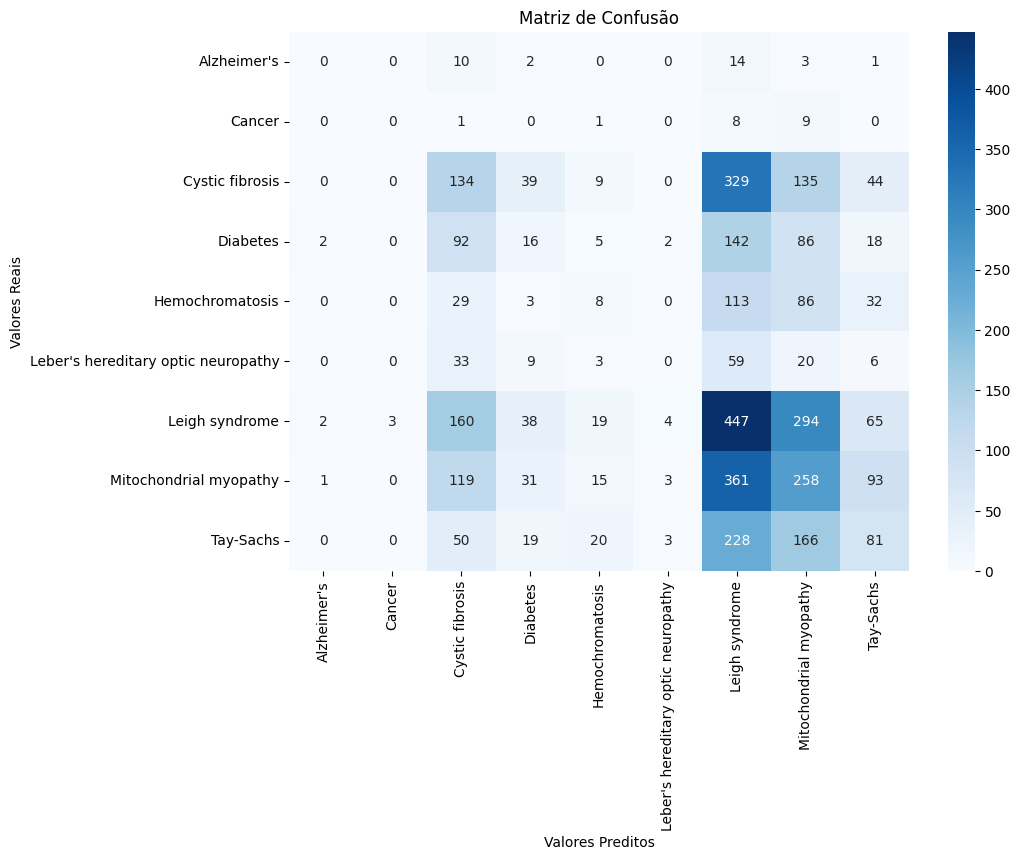

############################################################
# Modelo: RandomForestClassifier com hiperparameter tunning
############################################################
                                     precision    recall  f1-score   support

                        Alzheimer's       0.04      0.03      0.04        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.18      0.17      0.17       690
                           Diabetes       0.10      0.10      0.10       363
                    Hemochromatosis       0.12      0.10      0.11       271
Leber's hereditary optic neuropathy       0.04      0.04      0.04       130
                     Leigh syndrome       0.25      0.28      0.26      1032
             Mitochondrial myopathy       0.25      0.25      0.25       881
                          Tay-Sachs       0.19      0.18      0.19       567

                           accuracy           

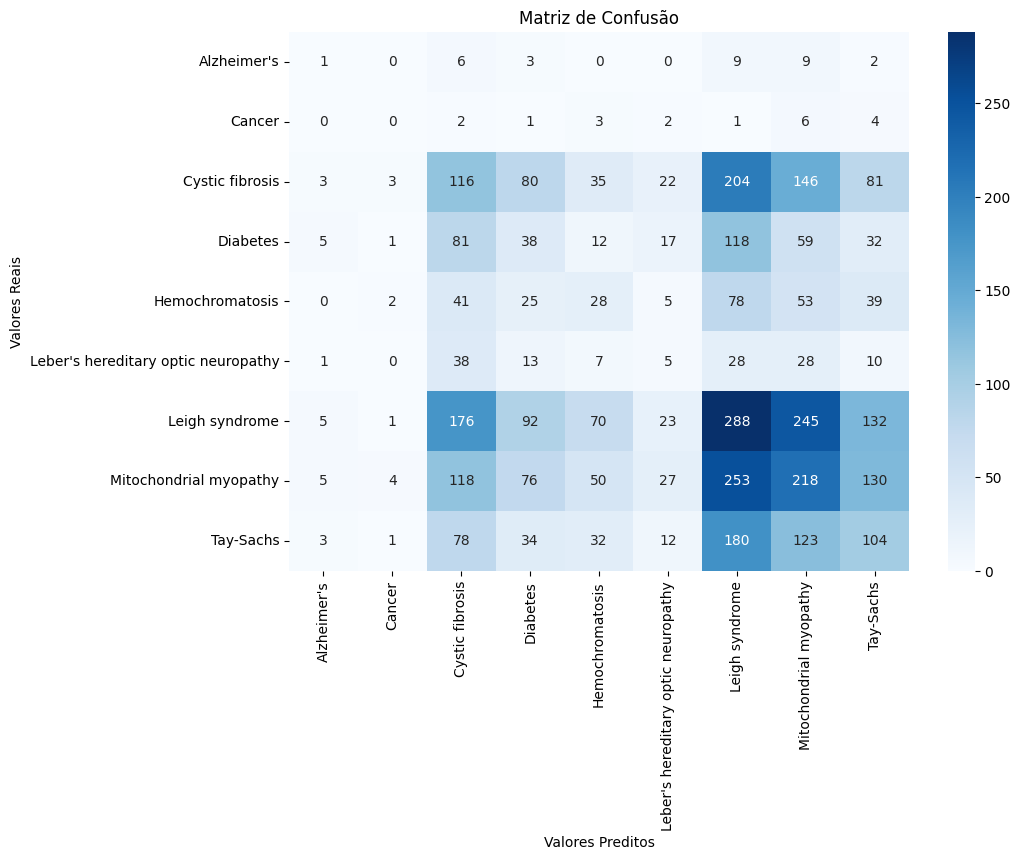

############################################################
# Modelo: DecisionTreeClassifier com hiperparameter tunning
############################################################
                                     precision    recall  f1-score   support

                        Alzheimer's       0.04      0.03      0.03        30
                             Cancer       0.00      0.00      0.00        19
                    Cystic fibrosis       0.18      0.19      0.18       690
                           Diabetes       0.08      0.07      0.08       363
                    Hemochromatosis       0.11      0.10      0.11       271
Leber's hereditary optic neuropathy       0.06      0.05      0.05       130
                     Leigh syndrome       0.25      0.28      0.26      1032
             Mitochondrial myopathy       0.25      0.24      0.25       881
                          Tay-Sachs       0.16      0.14      0.15       567

                           accuracy           

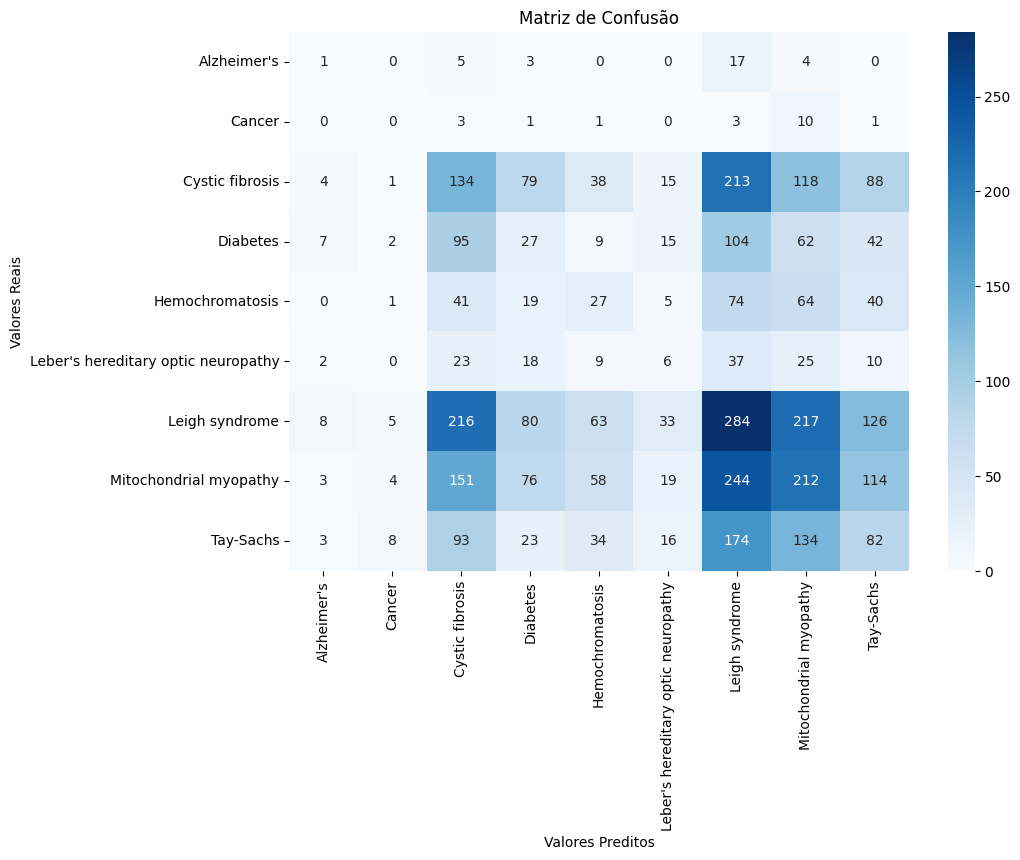

In [ ]:
for i, df_results in enumerate([df_results_inicial_1, df_results_tunned_1]):

  if i == 0:
    tunning = "sem"
    algorithms = ["XGBClassifier", "RandomForestClassifier","DecisionTreeClassifier", "DummyClassifier"]
  else:
    tunning = "com"
    algorithms = ["XGBClassifier", "RandomForestClassifier","DecisionTreeClassifier"]

  df_results.columns = [col.replace(".","_") for col in df_results.columns]


  for algorithm in algorithms:

    print(f"""############################################################
# Modelo: {algorithm} {tunning} hiperparameter tunning
############################################################""")

    results_clf = df_results[df_results.classifier == algorithm].squeeze(axis=0)
    y_pred = results_clf['y_pred']
    y_test = results_clf['y_test']
    print(classification_report(y_test, y_pred))
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plotar o heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Valores Preditos')
    plt.ylabel('Valores Reais')
    plt.title('Matriz de Confusão')
    plt.show()

    if algorithm == "DummyClassifier": continue

    importances = results_clf['importances']
    indices = np.argsort(importances)[::-1]  # Índices das features ordenados por importância
    feature_importances = list(zip(X_train.columns[:-1], importances))  # Associar importâncias aos nomes das features

    cols = X_train.columns

    cols, importances = [list(x) for x in zip(*sorted(zip(cols, importances),key = itemgetter(1)))]

    n = 20
    # Selecionando as n melhores features
    top_features = cols[:n]
    top_importances = importances[:n]

    # Criando o gráfico de barras com Plotly
    fig = go.Figure([go.Bar(x=top_features, y=top_importances)])
    fig.update_layout(
        title="Importância das Top {} Features".format(n),
        xaxis_title="Features",
        yaxis_title="Importância",
    )
    fig.show()

  print("\n\n\n\n\n\n\n\n")
